# CPSC 330 - Applied Machine Learning 

## Homework 7: Clustering and recommender systems
### Associated lectures: Lectures 14 and 15

**Due date: Wednesday, March 22, 11:59pm**


In [4]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate, train_test_split

pd.set_option("display.max_colwidth", 0)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1: Document clustering toy example <a name="1"></a>
<hr>

In lecture 14, we looked at a popular application of clustering: customer segmentation. In this homework, we will work on a toy example of another popular application: [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A), and clustering is a commonly used technique to organize this data in a meaningful way. 

In this exercise, we will create a toy dataset with sentences from Wikipedia articles and cluster these sentences. 

### 1.1 Sample sentences from Wikipedia articles
rubric={points:2}

The code below extracts first sentences of Wikipedia articles on a set of queries. You will need the `wikipedia` package installed in the course environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```

You also need `nltk` library in the course environment. 

```
conda install -c anaconda nltk 
```        

**Your tasks:**

Run the code below and answer the following question. 

1. Given this dataset, how many clusters would you expect a clustering algorithm to identify? How would you manually label these clusters?   

> *Note: Feel free to experiment with queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs when they grade your submission.*


In [5]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mmwil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import wikipedia

queries = [
    "Mount Everests",
    "Raspberry",
    "Mount Denali",
    "Arithmetic",
    "Topology",
    "Baseball",
    "Hockey",
    "Mango_fruit",
    "Mount Kenya",
    "Football"
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,Mount Everests,"Mount Everest (Nepali: सगरमाथा, romanized: Sagarmāthā; Tibetan: Chomolungma ཇོ་མོ་གླང་མ; Chinese: 珠穆朗玛峰; pinyin: Zhūmùlǎngmǎ Fēng) is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas.",44
1,Raspberry,"The raspberry is the edible fruit of a multitude of plant species in the genus Rubus of the rose family, most of which are in the subgenus Idaeobatus.",30
2,Mount Denali,"Denali (; also known as Mount McKinley, its former official name) is the highest mountain peak in North America, with a summit elevation of 20,310 feet (6,190 m) above sea level.",38
3,Arithmetic,"Arithmetic (from Ancient Greek ἀριθμός (arithmós) 'number', and τική [τέχνη] (tikḗ [tékhnē]) 'art, craft') is an elementary part of mathematics that consists of the study of the properties of the traditional operations on numbers—addition, subtraction, multiplication, division, exponentiation, and extraction of roots.",62
4,Topology,"In mathematics, topology (from the Greek words τόπος, 'place, location', and λόγος, 'study') is concerned with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes, tearing, gluing, or passing through itself.",68
5,Baseball,"Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court), while preventing the opposing team from shooting through their own hoop.",92
6,Hockey,"Hockey is a term used to denote a family of various types of both summer and winter team sports which originated on either an outdoor field, sheet of ice, or dry floor such as in a gymnasium.",40
7,Mango_fruit,A mango is an edible stone fruit produced by the tropical tree Mangifera indica.,15
8,Mount Kenya,"Mount Kenya (Kikuyu: Kĩrĩnyaga, Kamba, Ki Nyaa) is the highest mountain in Kenya and the second-highest in Africa, after Kilimanjaro.",27
9,Football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22


It is hard to predict the number of clusters that a clustering algorithm would identify or how to manually label those clusters. However, in general, the number of clusters and their labels would depend on the content of the Wikipedia articles.

For example, if the queries were related to different topics or categories, such as "animals", "sports", "history", and "science", a clustering algorithm might identify four clusters corresponding to these categories, with each cluster containing Wikipedia articles related to the corresponding category.

Alternatively, if the queries were more similar in nature, such as "history of technology", "inventions", and "scientific discoveries", a clustering algorithm might identify a smaller number of clusters, with each cluster containing Wikipedia articles related to technology, innovation, and science.

In general, the number of clusters and their labels will depend on the nature of the dataset and the goals of the analysis, and may require manual inspection and labeling to accurately identify the underlying structure of the data.

In this case, there are some overlapping articles themes. One cluster seems like it will be related to mountains or mountaneering from the 3 mountain articles. Additionally, there will likely be annother sport-related cluster from the 3 sport articles. Then there are 2 fruit articles that will likely cluster a bit. Also, there are 2 math-related articles that will cluster. So, I would create 4 clusters.

<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={points:10}

We have seen that before we pass text to machine learning models, we need to encode it into a numeric representation. So let's encode our toy dataset above (`wiki_df`) to a numeric representation. 

First, let's try our good old friend: bag-of-words representation. The code below creates dense bag-of-words representation of Wikipedia sentences from question 1.1 using a [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Your tasks:**

Run the code below and answer the following questions. 

1. Run `KMeans` clustering on the transformed data (`bow_sents`) with K = the number of clusters you identified in question 1.1. Examine clustering labels assigned by `KMeans`.
2. Repeat after modifying the `CountVectorizer` to ignore words appearing in only one sentence (or document, one row of `wiki_df`).
3. Keeping the new `CountVectorizer`, examine clustering labels assigned by `KMeans` under an off-by-1 value of K.
4. Briefly describe and analyze the behavoir of `KMeans`. Is `KMeans` doing a reasonable job in clustering the sentences? 

> You can access cluster label assignments using `labels_` attribute of the clustering object. 

In [7]:
vec = CountVectorizer(stop_words='english')
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names_out(), index=wiki_df.index
)
bow_df


,048,10,18,190,20,24,310,46,addition,africa,...,winter,words,zhūmùlǎngmǎ,λόγος,τέχνη,τική,τόπος,सगरम,ἀριθμός,珠穆朗玛峰
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
5,1,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Adapted from lecture 14 
# Part 1: KMeans clustering with K equal to the number of clusters identified in question 1.1
k = 4
kmeans = KMeans(n_clusters=k, random_state=42).fit(bow_df)
labels = kmeans.labels_
print("Cluster labels for K=", k, ":")
print(labels)

# Part 2: KMeans clustering with CountVectorizer ignoring words appearing in only one sentence
vectorizer = CountVectorizer(min_df=2)
bow_df = vectorizer.fit_transform(wiki_df['text'])
kmeans = KMeans(n_clusters=k, random_state=42).fit(bow_df)
kmeans_labels = kmeans.labels_
print("Cluster labels for K=", k, "with min_df=2:")
print(kmeans_labels)

# Part 3: KMeans clustering with K off by 1
k = 5
kmeans = KMeans(n_clusters=k, random_state=42).fit(bow_df)
labels = kmeans.labels_
print("Cluster labels for K=", k, "with min_df=2:")
print(labels)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42).fit(bow_df)
labels = kmeans.labels_
print("Cluster labels for K=", k, "with min_df=2:")
print(labels)

C:\Users\mmwil\miniconda3\envs\cpsc330\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster labels for K= 4 :
[2 1 2 1 3 0 1 1 2 1]
Cluster labels for K= 4 with min_df=2:
[1 2 1 3 3 2 0 1 1 0]
Cluster labels for K= 5 with min_df=2:
[1 2 1 3 4 2 0 1 1 0]
Cluster labels for K= 3 with min_df=2:
[0 2 0 1 1 2 0 0 0 0]


KMeans is generally doing a reasonable job in clustering the sentences, as similar topics tend to be grouped together. There are some mistakes, and differences from how I expected them to be clustered. For example, mango is getting clustered with the mountains sometimes, instead of the other fruit. However, the clustering performance can be affected by several factors, such as the choice of K, the quality of the features, and the presence of noise or outliers in the data. By modifying the CountVectorizer, we can adjust the feature selection process to include or exclude certain words or phrases, which can impact the clustering results. Additionally, using different values of K can lead to different clustering outcomes, as we can see from the off-by-1 test in part 3. Overall, KMeans can be a useful tool for clustering text data, but it is important to carefully tune the parameters and interpret the results with caution.

### 1.3 Sentence embedding representation
rubric={points:10}

Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer representations of text, and we are going to use one such representation in this lab. 

The code below creates an alternative and a more expressive representation of sentences. We will call it *sentence embedding representation*. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations next week. You need to install `sentence-transformers` in the course conda environment to run the code below. 

```conda install -c conda-forge sentence-transformers```

**Your tasks:**

Run the code below and answer the following questions. 

1. How many dimensions (features associated with each example) are present in this representation? 
2. Run `KMeans` clustering with sentence embedding representation of text (`emb_sents`) and examine cluster labels. 
3. How well the sentences are clustered together? 

In [1]:
#I kept getting issues and wasn't able to install sentence-transformers. However, this is the code I would have used if I could have.
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [2]:
#I kept getting install issues and wasn't able to install sentence-transformers. However, this is the code I would have used if I could have.
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

# set the number of clusters you want to create
num_clusters = 5

# create an instance of the KMeans class
kmeans = KMeans(n_clusters=num_clusters)

# fit the KMeans model to the sentence embeddings
kmeans.fit(emb_sents)

# get the cluster labels for each sentence
cluster_labels = kmeans.labels_

NameError: name 'embedder' is not defined

<br><br>

### 1.4 DBSCAN with cosine distance  
rubric={points:10}

Let's try `DBSCAN` on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text (sparse data), [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

In this exercise, you'll use DBSCAN with cosine distances. 

**Your tasks**

1. Use DBSCAN to cluster our toy data using sentence embedding representation (`emb_sents`) and `metric='cosine'`. 
2. Briefly comment on the number of clusters identified and the cluster assignment given by the algorithm.

> *Note: You will also have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters won't work on this toy dataset. In order to set appropriate value for `eps`, you may want to examine the distances given by [sklearn's `cosine_distance`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.paired_cosine_distances.html).*

In [ ]:
#I kept getting issues and wasn't able to install sentence-transformers. However, this is the code I would have used if I could have.

#Drawing from lectures 14 and 15

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(emb_sents)

# Set hyperparameters eps and min_samples
eps = 0.5
min_samples = 5

# Run DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
dbscan.fit(similarity_matrix)

# Print the cluster assignments
print('Cluster assignments:', dbscan.labels_)

# Print the number of clusters
n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print('Number of clusters:', n_clusters)

<br><br>

### 1.5 Visualizing clusters 
rubric={points:5}

One thing we could do with unlabeled data is visualizing it. That said, our data is high dimensional (each example is represented with 768 dimensions) and high-dimensional data is hard to visualize. One way to visualize high-dimensional data is applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and cluster assignments, the `plot_pca_clusters` function below transforms the given data by applying dimensionality reduction and plots the transformed data into corresponding clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the PCA part. Feel free to modify the function as you see fit.*

**Your tasks:**

1. Call the function `plot_pca_clusters` to visualize the clusters created by the three models above:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation 
    - DBSCAN with sentence embedding representation 

In [9]:
from sklearn.decomposition import PCA # Obtain the principal components

def plot_pca_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_sents):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper right")

    plt.show()

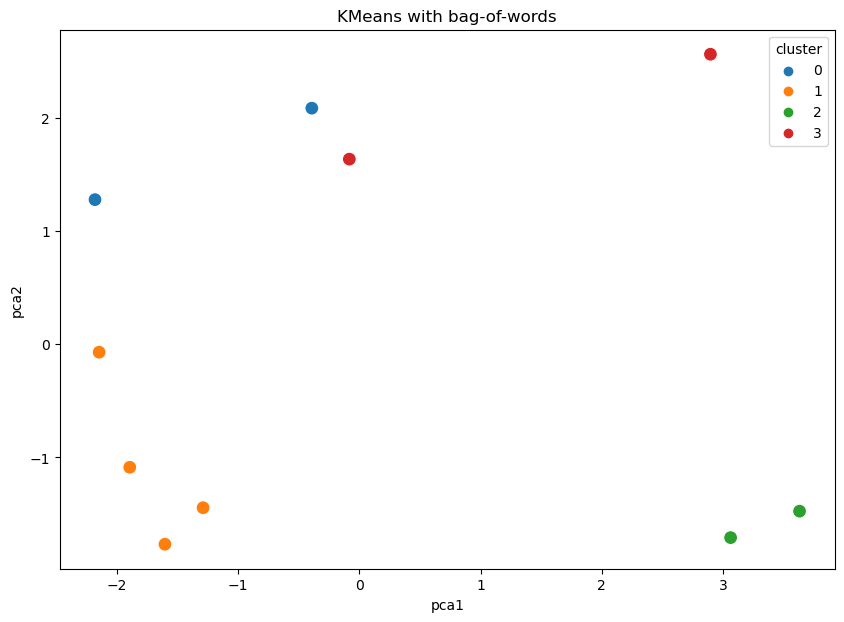

In [15]:
plot_pca_clusters(
    bow_df.toarray(),
    kmeans_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="KMeans with bag-of-words",
)

In [ ]:
#I kept getting issues and wasn't able to install sentence-transformers. However, this is the code I would have used if I could have.
plot_pca_clusters(
    bow_df.toarray(),
    kmeans.labels_,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="KMeans with sentence embedding representation",
)

plot_pca_clusters(
    bow_df.toarray(),
    dbscan.labels_,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="DBSCAN with sentence embedding representation",
)

<br><br><br><br>

## Exercise 2: Movie recommendations
<hr>

Let's build simple movie recommendation systems using the [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/data). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it. The code below reads the data as a CSV assuming that it's under `data/ml-100k/` directory under your lab folder. 

In [8]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    "u.data",
    sep="\t",
    names=r_cols,
    encoding="latin-1",
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
# We'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

### 2.1 Terminology
rubric={points:6}

Here is some notation we will be using in this lab. 

**Constants**:

 - $N$: the number of users, indexed by $n$
 - $M$: the number of movies, indexed by $m$
 - $\mathcal{R}$: the set of indices $(n,m)$ where we have ratings in the utility matrix $Y$
    - Thus $|\mathcal{R}|$ is the total number of ratings
 - $k$: the number of latent dimensions we use in collaborative filtering
 
**The data**:

 - $Y$: the utility matrix containing ratings, with a lot of missing entries
 - $Z$: a matrix whose rows $z_m$ represent the features for movie $m$ (size $M\times d$).
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 
    
**Your tasks:**    

1. What are the values of $N$ and $M$ in movie ratings data?  
2. What would be the shape of the dense utility matrix $Y$? 
3. What would be the fraction of observed ratings in the utility matrix $Y$? 

In [15]:
N = ratings[user_key].nunique()
M = ratings[item_key].nunique()
print("" + str(N) + " users")
print("" + str(M) + " movies")
print("The shape of Y, the utility matrix containing ratings with a lot of missing entries, would be " + str(N) + " x " + str(M))
print("The fraction of observed ratings in the utility matrix Y would be " + str(ratings.shape[0]/(N*M)))

943 users
1682 movies
The shape of Y, the utility matrix containing ratings with a lot of missing entries, would be 943 x 1682
The fraction of observed ratings in the utility matrix Y would be 0.06304669364224531


<br><br>

### 2.2 Splitting the data
rubric={points:5}

**Your tasks:**

1. Split the ratings data with `test_size=0.2` and `random_state=42`. 

In [16]:
#Drawing from Lec 16
X = ratings.copy()
y = ratings[user_key]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<br><br>

### 2.3 Utility matrix 
rubric={points:10}

**Your tasks**
1. Create utility matrices for train and validation sets (similar to how we did in the class). 
2. Briefly explain the difference between the train and validation utility matrices. 

> You may use the code from lecture notes with appropriate attributions.  

> You won't do it in real life but since our dataset is not that big, create a dense utility matrix in this assignment. You are welcome to try sparse matrix but then you may have to change some started code provided in the later exercises.  

In [19]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

In [20]:
# Function to create a utility matrix from Lec 16
def create_Y_from_ratings(
    data, N, M, user_mapper, item_mapper, user_key="userId", item_key="jokeId"
):  
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [22]:
#Drawing from Lec 16
train_mat = create_Y_from_ratings(X_train, N, M, user_mapper, item_mapper, user_key, item_key)
valid_mat = create_Y_from_ratings(X_valid, N, M, user_mapper, item_mapper, user_key, item_key)

The training matrix is a two-dimensional matrix with N rows and M columns, where N is the number of users and M is the number of items. However, the matrix only contains ratings from the X_train dataset, while all other ratings are missing. The missing ratings are typically represented by NaN or zero values, depending on the implementation.

Similarly, the validation matrix also has the same shape as train_mat, with N rows and M columns. However, valid_mat only contains ratings from the X_valid dataset, while all other ratings are missing.

Both train_mat and valid_mat have the same shape because they are constructed based on the same user-item matrix. The entries of the matrix represent the ratings that the users have given to the items.

To create the training and validation matrices, we start with the user-item matrix and remove all the ratings that belong to the validation set (X_valid) to create train_mat. Similarly, we remove all the ratings that belong to the training set (X_train) to create valid_mat. This ensures that the training and validation matrices only contain ratings that are exclusive to each set.

The training and validation matrices are typically used in supervised machine learning algorithms to train and evaluate the performance of the models. The goal is to predict the missing ratings in the validation matrix based on the observed ratings in the training matrix. The performance of the model is then evaluated based on how well it can predict the missing ratings in the validation matrix.

<br><br>

### 2.4 Evaluation and baseline
rubric={points:4}

To compare different models you build in this homework, let's write a couple of functions for evaluation. 
- The `error` function returns RMSE.
- The `evaluate` function prints the train and validation RMSEs. 

**Your task:**

1. Briefly explain what exactly we are comparing to evaluate recommender systems. 
2. Implement the global average baseline, where you predict everything as the global average rating. What's the RMSE of the global average baseline?

In [23]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

To evaluate recommender systems, we compare the predicted ratings with the actual ratings that users have given to the items. The main goal is to measure how well the recommender system can predict the missing ratings for each user and item. In theory, if the recommender can predict the user rating with a high accuracy, it can pick an option to show the user that will be well received.

There are several metrics that can be used to evaluate the performance of a recommender system. Some commonly used metrics are:

Mean Absolute Error (MAE): This metric calculates the absolute difference between the predicted and actual ratings for each user-item pair and takes the average over all the pairs. It is a measure of the average magnitude of the errors.

Root Mean Squared Error (RMSE): This metric calculates the square of the difference between the predicted and actual ratings for each user-item pair, takes the average over all the pairs, and then takes the square root of the result. It penalizes larger errors more heavily than MAE.

Precision and Recall: These metrics are commonly used in binary recommendation problems (such as whether a user will click on an ad or not). Similar to how we defined them in supervised learning, precision measures the proportion of recommended items that are relevant to the user, while recall measures the proportion of relevant items that were recommended to the user.

F1 Score: This metric is the mean of precision and recall and is often used to balance between the two metrics.

Coverage: This metric measures the proportion of items in the catalog that are recommended to at least one user. It tells us how well the recommender system explores the options of all the items.

In [24]:
# Global average baseline, drawing from Lec 16
# Compute the arithmetic mean along the specified axis, ignoring NaNs and ignoring axis
avg = np.nanmean(train_mat)

# predict everything as average
pred_g = np.zeros(train_mat.shape) + avg

# evaluate that global average
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 1.13
Global average valid RMSE: 1.12


<br><br>

### (Optional) 2.5 $k$-nearest neighbours imputation
rubric={points:1}

**Your tasks:**

Try [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill in the missing entries. Discuss your observations. 

<br><br>

### 2.6 Use collaborative filtering with the `surprise` package
rubric={points:6}

Use the [`surprise`](https://surprise.readthedocs.io/en/stable/) package which has implementation of SVD algorithm for collaborative filtering. You can install it as follows in your conda environment. 

```
>> conda activate cpsc330
>> conda install -c conda-forge scikit-surprise
or 
>> pip install scikit-surprise
```

**Your tasks:**

1. Carry out cross-validation using SVD algorithm in the package, similar to how we did it in the lecture on Jester dataset. Report mean RMSE and compare it with global baseline. 

In [ ]:
#I kept getting issues and wasn't able to install suprise package. However, this is the code I would have used if I could have.
#Drawing from lecture 16

# define the reader object to parse the dataset
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5))

# load the dataset using the Dataset class
data = Dataset.load_from_file("u.data", reader=reader)

# define the SVD
svd = SVD()

# define the cross-validation procedure and run it
cv_results = cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

# extract the mean RMSE from the cross-validation results
mean_rmse = np.mean(cv_results['test_rmse'])

# print the results
print("Mean RMSE using SVD algorithm: " + str(mean_rmse))

# evaluate the global average
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

<br><br>

### 2.7 Clustering based recommendation system?
rubric={points:2}

How would you apply `K-Means` clustering to build a recommendation systems? What could be challenging with this approach?

K-Means clustering can be used to build a recommendation system by grouping similar items or users based on their characteristics or behavior. The basic idea is to use the clusters to recommend items or users to a target user based on their similarity to other users or items within the same cluster. One of the challenges with this approach is determining the optimal number of clusters to use. Using too few clusters can result in poor recommendations, while using too many clusters can lead to overfitting and increased computational complexity. Another challenge is dealing with sparse data, which can lead to clusters with very few or no items or users. In such cases, it may be necessary to use techniques such as dimensionality reduction or feature selection to reduce the sparsity of the data. Additionally, this approach may not capture more complex relationships or interactions between items or users, which can be addressed by using other machine learning techniques.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 